# 📊 Previsão de Séries Temporais com RNN (LSTM) - Ações da Apple

## 📌 Sobre o Projeto
Este projeto utiliza uma **Rede Neural Recorrente (RNN) com LSTMs** para prever **preços de ações** com base em dados históricos.

### **📌 O que o código faz?**
✅ **Baixa os dados históricos da Apple (AAPL) via Yahoo Finance**  
✅ **Normaliza os preços e cria sequências para treino**  
✅ **Treina um modelo RNN com LSTM para prever preços futuros**  
✅ **Avalia o erro da previsão (MAE - Mean Absolute Error)**  
✅ **Plota gráficos dos preços reais vs. previstos**  

---

## 📊 **Melhoria do Modelo**
✔ **Uso de LSTM** → Melhor aprendizado de padrões temporais  
✔ **Regularização com Dropout** → Reduz overfitting  
✔ **Otimização com Adam** → Acelera o aprendizado  
✔ **Treinamento com 50 épocas** → Melhor estabilidade  

---

## 🔧 **Requisitos**
Antes de rodar o código, instale as dependências necessárias:

```bash
pip install tensorflow numpy pandas matplotlib seaborn scikit-learn yfinance


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0423 - val_loss: 0.0079
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0037 - val_loss: 0.0057
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step

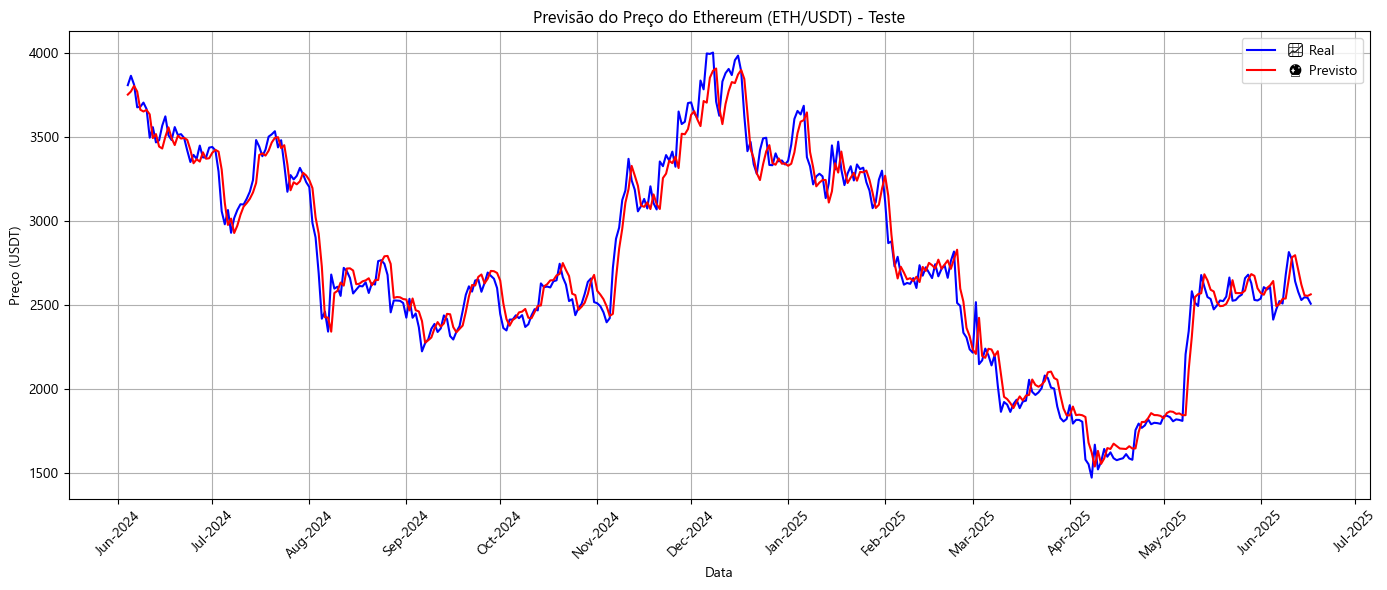

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


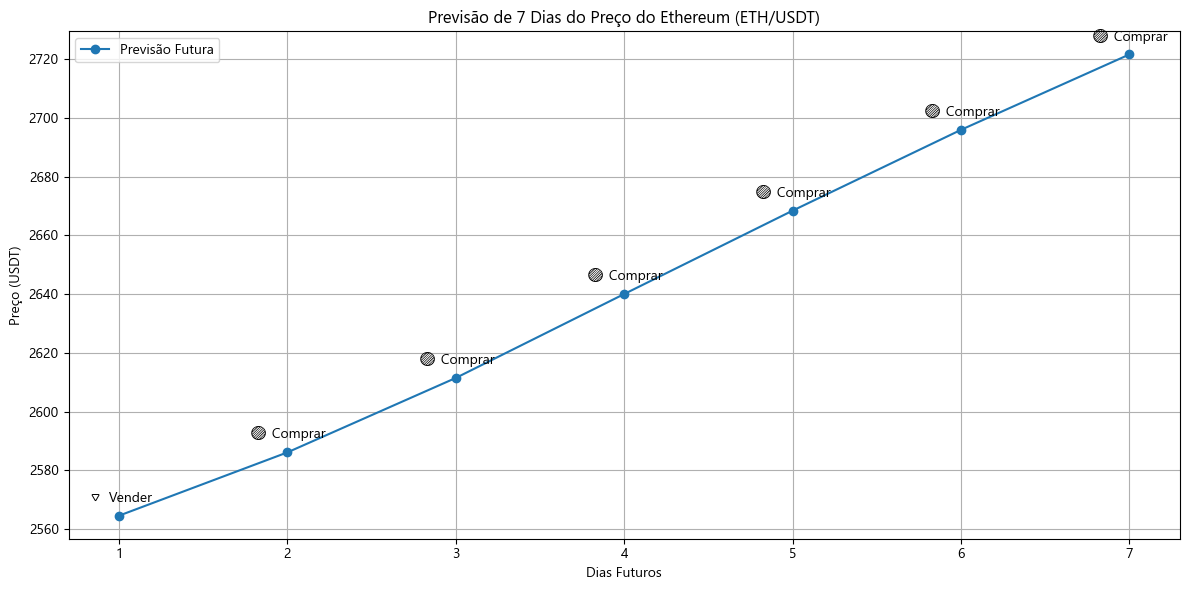


📈 Avaliação do Modelo:
 Métrica     Valor                                                      Descrição
     MAE 78.414170                  Erro absoluto médio (diferença média em USDT)
    MAPE  0.029316               Erro percentual médio (em relação ao valor real)
R² Score  0.969499 Coeficiente de determinação (quanto mais próximo de 1, melhor)


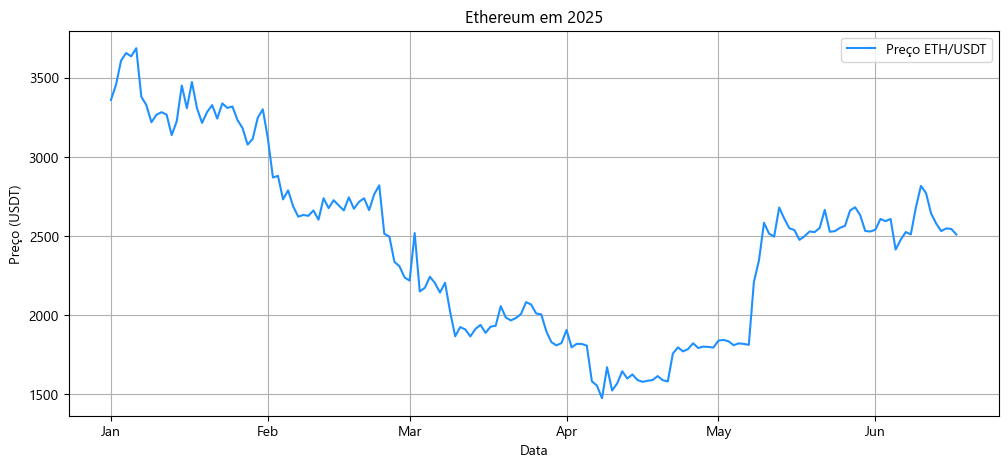

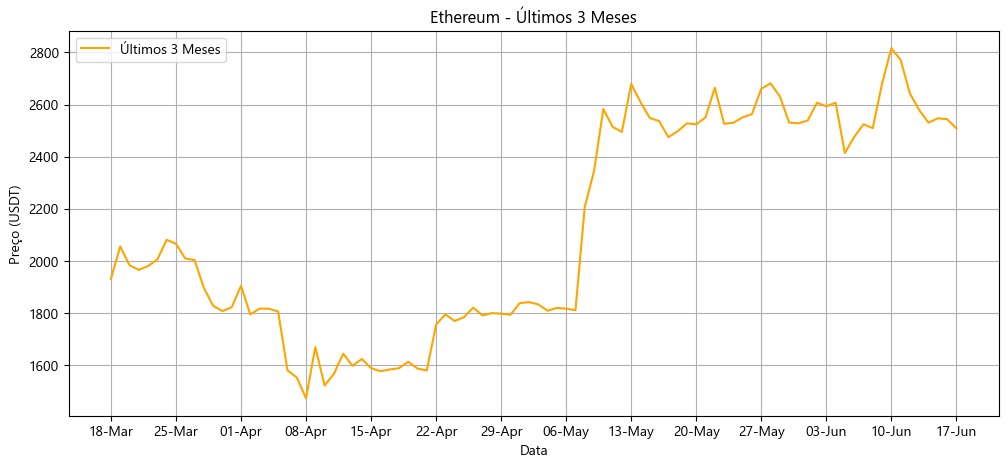

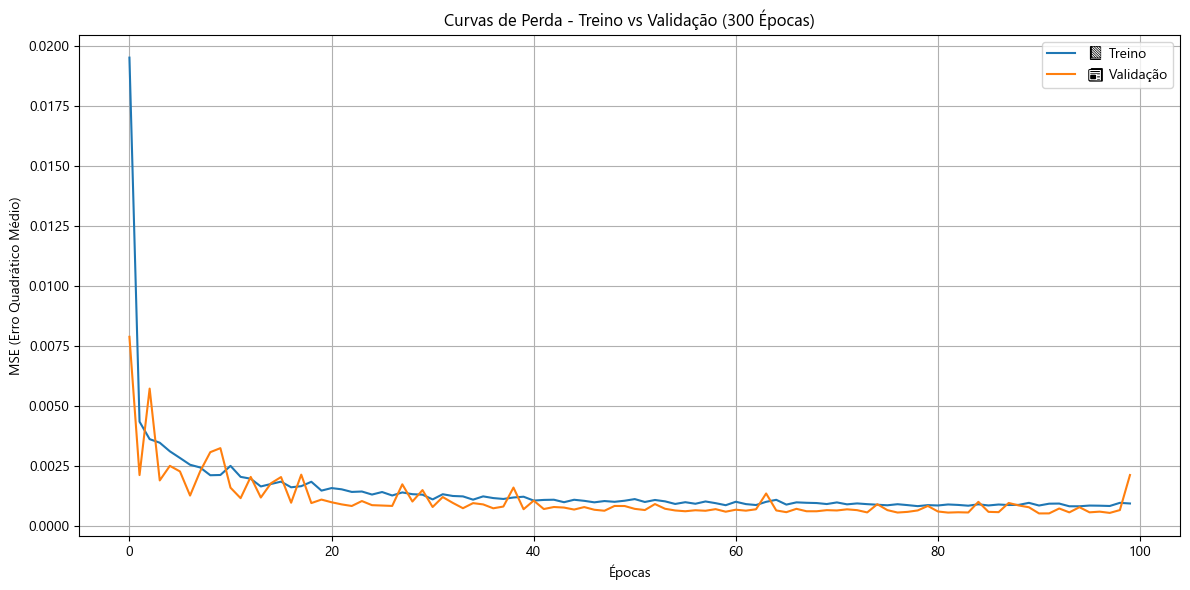

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from binance.client import Client

plt.rcParams['font.family'] = 'Segoe UI Emoji'

# 1. Coletar dados da Binance (ETH/USDT)
client = Client()
klines = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1DAY, "1 Jan, 2020")

# 2. Preparar DataFrame
df = pd.DataFrame(klines, columns=[
    'timestamp', 'open', 'high', 'low', 'close', 'volume',
    'close_time', 'quote_asset_volume', 'number_of_trades',
    'taker_buy_base', 'taker_buy_quote', 'ignore'
])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)
df_modelo = df[['open', 'high', 'low', 'close', 'volume']].astype(float)

# 3. Normalizar os dados
scaler = MinMaxScaler()
dados_normalizados = scaler.fit_transform(df_modelo)

# 4. Criar sequências
def criar_sequencias_multivariadas(dados, n_steps=100):
    X, y = [], []
    for i in range(len(dados) - n_steps):
        X.append(dados[i:i+n_steps])
        y.append(dados[i+n_steps, 3])  # índice 3 = 'close'
    return np.array(X), np.array(y)

n_steps = 100
X, y = criar_sequencias_multivariadas(dados_normalizados, n_steps)

# 5. Separar treino/teste
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# 6. Modelo com Bidirectional LSTM
modelo = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(n_steps, X.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])
modelo.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
historico = modelo.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# 7. Previsão
previsoes = modelo.predict(X_test)
previsoes_reais = scaler.inverse_transform(np.hstack([
    np.zeros((len(previsoes), 3)), previsoes, np.zeros((len(previsoes), 1))
]))[:, 3]
y_test_reais = scaler.inverse_transform(np.hstack([
    np.zeros((len(y_test), 3)), y_test.reshape(-1, 1), np.zeros((len(y_test), 1))
]))[:, 3]

mae = mean_absolute_error(y_test_reais, previsoes_reais)
mape = mean_absolute_percentage_error(y_test_reais, previsoes_reais)
r2 = r2_score(y_test_reais, previsoes_reais)

# 8. Recuperar as datas correspondentes ao y_test
datas_reais = df.index[-len(y_test_reais):]

plt.figure(figsize=(14, 6))
plt.plot(datas_reais, y_test_reais, label='📈 Real', color='blue')
plt.plot(datas_reais, previsoes_reais, label='🔮 Previsto', color='red')
plt.title("Previsão do Preço do Ethereum (ETH/USDT) - Teste")
plt.xlabel("Data")
plt.ylabel("Preço (USDT)")
plt.legend()
plt.grid(True)

# Melhorar visualização das datas no eixo X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 9. Previsão dos próximos 7 dias
entrada = X_test[-1:]
futuro_normalizado = []
for _ in range(7):
    pred = modelo.predict(entrada)
    futuro_normalizado.append(pred[0])
    nova_linha = entrada[:, -1:, :].copy()
    nova_linha[:, 0, 3] = pred
    entrada = np.append(entrada[:, 1:, :], nova_linha, axis=1)

futuro = scaler.inverse_transform(np.hstack([
    np.zeros((7, 3)), np.array(futuro_normalizado), np.zeros((7, 1))
]))[:, 3]

acoes = []
for i in range(len(futuro)):
    if i == 0 or futuro[i] < futuro[i-1]:
        acoes.append('🔻 Vender')
    elif futuro[i] > futuro[i-1] * 1.002:
        acoes.append('🟢 Comprar')
    else:
        acoes.append('⚠️ Atenção')

# 10. Gráfico de Decisão
plt.figure(figsize=(12, 6))
plt.plot(range(1, 8), futuro, marker='o', label='Previsão Futura')
for i, txt in enumerate(acoes):
    plt.annotate(txt, (i + 1, futuro[i]), textcoords="offset points", xytext=(0, 10), ha='center')
plt.title("Previsão de 7 Dias do Preço do Ethereum (ETH/USDT)")
plt.xlabel("Dias Futuros")
plt.ylabel("Preço (USDT)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Gráfico Ethereum 2025
df_2025 = df[df.index.year == 2025].copy()
df_2025['close'] = pd.to_numeric(df_2025['close'], errors='coerce')
df_2025 = df_2025.dropna(subset=['close'])

fig1, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(df_2025.index, df_2025['close'], label="Preço ETH/USDT", color='dodgerblue')
ax1.set_title("Ethereum em 2025")
ax1.set_xlabel("Data")
ax1.set_ylabel("Preço (USDT)")
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.ticklabel_format(axis='y', style='plain')  # remove notação científica
ax1.grid(True)
ax1.legend()

# 12. Gráfico Últimos 3 Meses
ultimos_3_meses = df[df.index > df.index.max() - pd.DateOffset(months=3)].copy()
ultimos_3_meses['close'] = pd.to_numeric(ultimos_3_meses['close'], errors='coerce')
ultimos_3_meses = ultimos_3_meses.dropna(subset=['close'])

fig2, ax2 = plt.subplots(figsize=(12, 5))
ax2.plot(ultimos_3_meses.index, ultimos_3_meses['close'], label="Últimos 3 Meses", color='orange')
ax2.set_title("Ethereum - Últimos 3 Meses")
ax2.set_xlabel("Data")
ax2.set_ylabel("Preço (USDT)")
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax2.ticklabel_format(axis='y', style='plain')  # remove notação científica
ax2.grid(True)
ax2.legend()

# 13. Tabela Avaliação
avaliacao = pd.DataFrame({
    "Métrica": ["MAE", "MAPE", "R² Score"],
    "Valor": [mae, mape, r2],
    "Descrição": [
        "Erro absoluto médio (diferença média em USDT)",
        "Erro percentual médio (em relação ao valor real)",
        "Coeficiente de determinação (quanto mais próximo de 1, melhor)"
    ]
})
print("\n📈 Avaliação do Modelo:")
print(avaliacao.to_string(index=False))

# 14. Verificar Overfitting com Curva de perda
plt.figure(figsize=(12, 6))
plt.plot(historico.history['loss'], label='📘 Treino')
plt.plot(historico.history['val_loss'], label='📰 Validação')
plt.title("Curvas de Perda - Treino vs Validação (300 Épocas)")
plt.xlabel("Épocas")
plt.ylabel("MSE (Erro Quadrático Médio)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

